In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv("../data/train.csv")

In [2]:
# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 1]
train = train[train["POLYLINE"] != "[]"]
train = train[["POLYLINE"]]
# Choose 10000 rows randomly from dataset to run
train_1 = train.sample(10000)

train_1

,POLYLINE
479854,"[[-8.600049,41.182731],[-8.600265,41.182794],[..."
1073173,"[[-8.602875,41.179635],[-8.603298,41.179941],[..."
1416908,"[[-8.611002,41.146101],[-8.610813,41.145471],[..."
818366,"[[-8.649576,41.167251],[-8.649729,41.1669],[-8..."
262163,"[[-8.600238,41.182722],[-8.599806,41.182695],[..."
...,...
1582011,"[[-8.640738,41.159988],[-8.640837,41.159988],[..."
136183,"[[-8.610966,41.145498],[-8.610993,41.145588],[..."
166141,"[[-8.585631,41.148504],[-8.585703,41.148711],[..."
48689,"[[-8.578161,41.192397],[-8.578719,41.191578],[..."


In [3]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = float("-inf"), float("inf"), float("-inf"), float("inf")
    for cord in cords_raw:
        cords.append([float(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [4]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat):
    final = [[(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)] for cord in polyline]
    return pd.Series({"POLYLINE_INIT": final[:-1], "POLYLINE_DEST": final[-1]})

In [5]:
def _to_matrix(polyline, m):
    mat = np.zeros((m, m))
    n = len(polyline)
    for i in range(n):
        x = min(m - 1, int(polyline[i][0] * m))
        y = min(m - 1, int(polyline[i][1] * m))
        mat[y][x] = (i + 1) / n
    return mat

In [6]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    df_train["POLYLINE"] = changed["POLYLINE"]
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = train_1["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude))
    # Transform to matrices
    cleaned["MATRIX"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    return cleaned

In [7]:
transformed = transform(train_1, 256)

In [8]:
import matplotlib.pyplot as plt

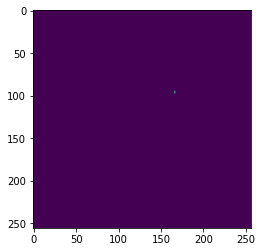

In [9]:
mat = transformed["MATRIX"].iloc[0]

plt.imshow(mat)
plt.show()

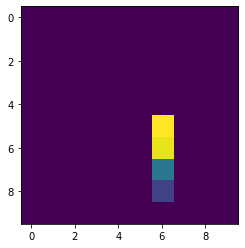

In [10]:
plt.imshow(mat[90:100, 160:170])
plt.show()